<a href="https://colab.research.google.com/github/CaioWing/Bootcamp-InovaUSP/blob/main/desafio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ordem Esperada para as classes no dataset de recicláveis:

- Class 0: bottle-blue
- Class 1: bottle-blue-full
- Class 2: bottle-blue5l
- Class 3: bottle-blue5l-full
- Class 4: bottle-dark
- Class 5: bottle-dark-full
- Class 6: bottle-green
- Class 7: bottle-green-full
- Class 8: bottle-milk
- Class 9: bottle-milk-full
- Class 10: bottle-multicolor
- Class 11: bottle-multicolorv-full
- Class 12: bottle-oil
- Class 13: bottle-oil-full
- Class 14: bottle-transp
- Class 15: bottle-transp-full
- Class 16: bottle-yogurt
- Class 17: glass-dark
- Class 18: glass-green
- Class 19: glass-transp
- Class 20: canister
- Class 21: cans
- Class 22: juice-cardboard
- Class 23: milk-cardboard
- Class 24: detergent-box
- Class 25: detergent-color
- Class 26: detergent-transparent
- Class 27: detergent-white


#### Download do Dataset

Neste exemplo estamos usando o dataset [Fruits and Vegetables Image Recognition Dataset](https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition), disponível sob a licensa [CC0: Public Domain](https://creativecommons.org/publicdomain/zero/1.0/).

Por estar disponível sob uma licensa de domínio público, podemos fazer basicamente o que quisermos com esse dataset, inclusive redistribuir ele.


O dataset a ser usado na avaliação está disponível em:

- Treinamento: https://docs.toradex.com/private/114105-recyclables_train.zip​
- Validação: https://docs.toradex.com/private/114106-recyclables_validation.zip

In [1]:
# Baixar e descompactar o dataset
!mkdir dataset
!wget -q https://docs.toradex.com/private/114106-recyclables_validation.zip \
         https://docs.toradex.com/private/114105-recyclables_train.zip​
!unzip -q '*.zip' -d dataset/
# Definir o caminho do dataset
data_path = "dataset"

In [2]:
!unzip -q '/content/114105-recyclables_train.zip​' -d dataset/

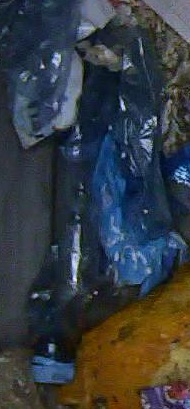

In [3]:
from IPython.display import Image
Image("/content/dataset/train_crops/bottle/bottle-blue/Monitoring_photo1_04-Mar_03-09-16_01.jpg", width=256)


In [4]:
# Instalar Pytorch, Torchvision, Tensorboard e utilidades parar ver o progresso do treinamento
!pip install -q torch torchvision torcheval tensorboard matplotlib tqdm tensorflow ipywidgets seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.5 MB/s eta 0:00:00


In [5]:
# Módulos, classes e funções que são úteis para inferência e treinamento
import torch, torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image
from torcheval.metrics import MulticlassF1Score, MulticlassRecall, MulticlassPrecision

# Suporte a TensorBoard no PyTorch
from torch.utils.tensorboard import SummaryWriter

# Utiliades do sistema
from datetime import datetime
import time
import os

# O Tqdm é utilizado para criar barras de progresso
from tqdm.notebook import tqdm


print(torch.__version__)

2.1.0+cu118


In [50]:
list_paths = [
    "/content/dataset/train_crops/bottle",
    "/content/dataset/train_crops/canister",
    "/content/dataset/train_crops/cans",
    "/content/dataset/train_crops/cardboard",
    "/content/dataset/train_crops/detergent"
]

def get_paths(
    root_paths : list[str]
):
#ler tudo que esta dentro do path raiz, pegar o nome da pasta como classe, e relacionar do path da imagem
  all_images = []
  all_classes = []
  index = 0

  def get_images(class_path, index):
    images = []
    classes = []
    class_images = os.listdir(class_path)
    for image in class_images:
      if(not (image.endswith(".jpg") or image.endswith(".JPG") or image.endswith(".png") or image.endswith(".PNG"))):
          continue
      image_path = os.path.join(class_path, image)
      #tuple -> path da imagem e um index referente a classe

      images.append(image_path)
      classes.append(index)
    return images, classes

  for root_path in root_paths:
    initial_paths = [root_path + "/" + p for p in sorted(os.listdir(root_path))]
    #print("initiacl path: ", initial_paths)
    for class_path in initial_paths:
      images, classes = get_images(class_path, index)
      all_images.append(images)
      all_classes.append(classes)
      index += 1
  return all_images, all_classes

os.listdir(list_paths[0])

['bottle-blue',
 'bottle-green',
 'bottle-blue5l',
 'bottle-transp',
 'bottle-yogurt',
 'bottle-oil-full',
 'bottle-blue5l-full',
 'glass-transp',
 'bottle-milk-full',
 'bottle-multicolor',
 'bottle-blue-full',
 'bottle-multicolorv-full',
 'glass-green',
 'bottle-transp-full',
 'glass-dark',
 'bottle-oil',
 'bottle-milk',
 'bottle-green-full',
 'bottle-dark',
 'bottle-dark-full']

In [53]:
a, b = get_paths(list_paths)

In [46]:
# Declaração da classe herdando de Dataset
class CustomDataset(Dataset):

    # Construtor
    def __init__(self, images_dir : list[str], preprocess_function = None):
        """
        Args:
            images_dir (string): Directory with all the image folders
            preprocess_function (callable): Transform to be applied on a sample
        """
        self.image_paths = []
        self.image_classes = []
        self.images, self.classes = get_paths(images_dir)
        self.transform = preprocess_function

        for i in range(len(self.list_classes)):
          self.image_paths.append(self.list_classes[i][0])
          self.image_classes.append(self.list_classes[i][1])

        self.classes = set(self.image_classes)

    def __len__(self):
        return len(set(self.image_paths))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Checagem por erros na leitura da imagem
        # Isso gera uma nova excessão para que o dataset seja corrigido, não queremos imagens com problemas no dataset
        #print(self.image_paths)
        try:
            sample = read_image(self.image_paths[idx][0], torchvision.io.ImageReadMode.RGB)
        except:
            print(f"Problem loading image {self.image_paths[idx]}")
            raise Exception()

        if self.transform != None:
          sample = self.transform(sample)

        # Retorno do par (imagem, classe)
        return sample, self.image_classes[idx][1]

In [49]:
train_list_paths = [
    "/content/dataset/train_crops/bottle",
    "/content/dataset/train_crops/canister",
    "/content/dataset/train_crops/cans",
    "/content/dataset/train_crops/cardboard",
    "/content/dataset/train_crops/detergent"
]


train_dataset = CustomDataset(train_list_paths)

for a,b in train_dataset:
  print(b)
  break

train_dataset.image_classes

0


[('/content/dataset/train_crops/bottle/bottle-blue/POSAD_1_13-Sep_04-16-07_01.jpg',
  0),
 ('/content/dataset/train_crops/bottle/bottle-blue-full/POSAD_1_11-Sep_14-38-53_01.jpg',
  1),
 ('/content/dataset/train_crops/bottle/bottle-blue5l/Robo_25-Mar_14-49-43_01.jpg',
  2),
 ('/content/dataset/train_crops/bottle/bottle-blue5l-full/POSAD_1_12-Sep_22-50-20_01.jpg',
  3),
 ('/content/dataset/train_crops/bottle/bottle-dark/POSAD_1_12-Sep_17-00-52_01.jpg',
  4),
 ('/content/dataset/train_crops/bottle/bottle-dark-full/Monitoring_photo1_04-Mar_04-17-50_01.jpg',
  5),
 ('/content/dataset/train_crops/bottle/bottle-green/Robo_25-Mar_12-04-45_01.jpg',
  6),
 ('/content/dataset/train_crops/bottle/bottle-green-full/POSAD_1_12-Sep_17-14-54_01.jpg',
  7),
 ('/content/dataset/train_crops/bottle/bottle-milk/POSAD_1_13-Sep_02-10-39_01.jpg',
  8),
 ('/content/dataset/train_crops/bottle/bottle-milk-full/POSAD_1_11-Sep_14-38-53_01.jpg',
  9),
 ('/content/dataset/train_crops/bottle/bottle-multicolor/POSAD_1_

In [20]:
batch_size = 32
inference_size = 160
NormalizationMean = [0.485, 0.456, 0.406]
NormalizationStd = [0.229, 0.224, 0.225]

preprocess_image = transforms.Compose([
    transforms.Resize((inference_size, inference_size), antialias=True),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=NormalizationMean, std=NormalizationStd),
])

In [41]:
train_list_paths = [
    "/content/dataset/train_crops/bottle",
    "/content/dataset/train_crops/canister",
    "/content/dataset/train_crops/cans",
    "/content/dataset/train_crops/cardboard",
    "/content/dataset/train_crops/detergent"
]

test_list_paths = [
    "/content/dataset/validation_crops/bottle",
    "/content/dataset/validation_crops/canister",
    "/content/dataset/validation_crops/cans",
    "/content/dataset/validation_crops/cardboard",
    "/content/dataset/validation_crops/detergent"
]


train_dataset = CustomDataset(train_list_paths, preprocess_image)
test_dataset = CustomDataset(test_list_paths, preprocess_image)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=1)


print( "Train dataset information:")
print(f" |-> Length:        {len(train_dataset)}")
print(f" '-> Loader length: {len(train_dataloader)}")


print( "Test dataset information:")
print(f" |-> Length:        {len(test_dataset)}")
print(f" '-> Loader length: {len(test_dataloader)}")

Train dataset information:
 |-> Length:        28
 '-> Loader length: 1
Test dataset information:
 |-> Length:        28
 '-> Loader length: 1


In [38]:
for a,b in train_dataset:
  print(b)
  break

0


In [30]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=torchvision.models.ResNet50_Weights.DEFAULT)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [31]:
def train_one_epoch(model, dataloader, optimizer, loss_function, epoch_index, device, tensorboard_writer):
    running_loss = 0.0
    last_loss = 0.0

    model.to(device)

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    print(f"Training Epoch {epoch_index}:")

    progress_bar = tqdm(total=len(dataloader))
    for i, data in enumerate(dataloader):

        # Every data instance is an input + label pair
        inputs, labels = data
        inputs = torch.tensor(inputs)
        labels = torch.tensor(labels)

        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero gradients for every batch
        optimizer.zero_grad()

        # Run Inference on the training data
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_function(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 10 == 9:
            last_loss = running_loss / 10 # loss per batch
            tb_x = (epoch_index*len(train_dataloader)) + i
            tensorboard_writer.add_scalar('Loss/train', last_loss, tb_x)
            tensorboard_writer.flush()
            running_loss = 0.0

        del inputs, labels

        progress_bar.update(1)
    return last_loss

In [32]:

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
tensorboard_writer = SummaryWriter(f'runs/model_{timestamp}')

EPOCHS = 10

best_validation_loss = -1

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

device = 'cpu'
if(torch.cuda.is_available()):
    device = 'cuda'

for epoch in range(EPOCHS):
    print(f'EPOCH {epoch}:')

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(model, train_dataloader, optimizer, loss_function, epoch, device, tensorboard_writer)

    running_validation_loss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    model.to(device)

    precision_metric = MulticlassPrecision(average='weighted', num_classes=len(test_dataset.classes))
    recall_metric = MulticlassRecall(average='weighted', num_classes=len(test_dataset.classes))
    f1score_metric = MulticlassF1Score(average='weighted', num_classes=len(test_dataset.classes))

    # Disable gradient computation and reduce memory consumption.
    print(f"Running Validation for Epoch {epoch}")
    with torch.no_grad():
        progress_bar = tqdm(total=len(test_dataset))
        for validation_data in test_dataloader:
            validation_inputs, validation_labels = validation_data
            validation_inputs = validation_inputs.to(device)
            validation_labels = validation_labels.to(device)
            validation_outputs = model(validation_inputs)
            running_validation_loss += loss_function(validation_outputs, validation_labels)

            output_labels = []

            for j in range(0, validation_outputs.size()[0]):
                probabilities = torch.nn.functional.softmax(validation_outputs[j], dim=0)
                prob, det_class = torch.topk(probabilities, 1)
                # If the detected class is outside of bounds, give a wrong result within bounds
                if(det_class >= len(test_dataset.classes)):
                    det_class = validation_labels[j].item()-1
                    if(det_class < 0):
                        det_class = validation_labels[j].item()+1
                output_labels.append(det_class)

            output_labels = torch.as_tensor(output_labels)
            output_labels.to(device)

            precision_metric.update(output_labels, validation_labels)
            recall_metric.update(output_labels, validation_labels)
            f1score_metric.update(output_labels, validation_labels)

            del validation_inputs, validation_labels, output_labels

            progress_bar.update(1)

    precision = precision_metric.compute().item()
    recall = recall_metric.compute().item()
    f1score = f1score_metric.compute().item()

    average_validation_loss = running_validation_loss / len(test_dataloader)

    # Log the running loss averaged per batch
    # for both training and validation
    tensorboard_writer.add_scalars('Training vs. Validation Loss',
                                  { 'Training': avg_loss,
                                    'Validation': average_validation_loss},
                                    epoch)

    tensorboard_writer.add_scalars('Validation Metrics',
                                  { 'Precision': precision,
                                    'Recall': recall,
                                    'F1 Score': f1score},
                                    epoch)
    tensorboard_writer.flush()

    tensorboard_writer.add_scalars('Learning Rate',
                                  {'lr': optimizer.state_dict()['param_groups'][0]['lr']},
                                    epoch)
    tensorboard_writer.flush()

    # Track best performance, and save the model's state
    if((average_validation_loss < best_validation_loss) or (best_validation_loss == -1)):
        best_validation_loss = average_validation_loss
        torch.save(model.state_dict(), f'model_{timestamp}_best')

    torch.save(model.state_dict(), f'model_{timestamp}_{epoch}')


EPOCH 0:
Training Epoch 0:


  0%|          | 0/1 [00:00<?, ?it/s]

<ipython-input-31-72873a6b588a>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs)
<ipython-input-31-72873a6b588a>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


Running Validation for Epoch 0


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH 1:
Training Epoch 1:


  0%|          | 0/1 [00:00<?, ?it/s]

Running Validation for Epoch 1


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH 2:
Training Epoch 2:


  0%|          | 0/1 [00:00<?, ?it/s]

Running Validation for Epoch 2


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH 3:
Training Epoch 3:


  0%|          | 0/1 [00:00<?, ?it/s]

Running Validation for Epoch 3


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH 4:
Training Epoch 4:


  0%|          | 0/1 [00:00<?, ?it/s]

Running Validation for Epoch 4


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH 5:
Training Epoch 5:


  0%|          | 0/1 [00:00<?, ?it/s]

Running Validation for Epoch 5


  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH 6:
Training Epoch 6:


  0%|          | 0/1 [00:00<?, ?it/s]

Running Validation for Epoch 6


  0%|          | 0/28 [00:00<?, ?it/s]

KeyboardInterrupt: ignored